# Parte 1: Carga y Exploración Inicial de Datos
1. Carga del Dataset:
Cargar el dataset desde Kaggle.
2. Exploración Inicial:
Revisar la estructura del dataset.
Describir las variables y su distribución.
Identificar y documentar valores faltantes y outliers.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


df = pd.read_csv('../Data/train.csv')
df.head().T

,0,1,2,3,4
Loan_ID,LP001002,LP001003,LP001005,LP001006,LP001008
Gender,Male,Male,Male,Male,Male
Married,No,Yes,Yes,Yes,No
Dependents,0,1,0,0,0
Education,Graduate,Graduate,Graduate,Not Graduate,Graduate
Self_Employed,No,No,Yes,No,No
ApplicantIncome,5849,4583,3000,2583,6000
CoapplicantIncome,0.0,1508.0,0.0,2358.0,0.0
LoanAmount,NaN,128.0,66.0,120.0,141.0
Loan_Amount_Term,360.0,360.0,360.0,360.0,360.0


In [2]:
print(df.dtypes)

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object


In [3]:
# Identificar valores nulos
print("Valores nulos:\n", df.isnull().sum())
# Identificación y eliminación de duplicados
print("Valores duplicados:", df.duplicated().sum())

Valores nulos:
 Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
Valores duplicados: 0


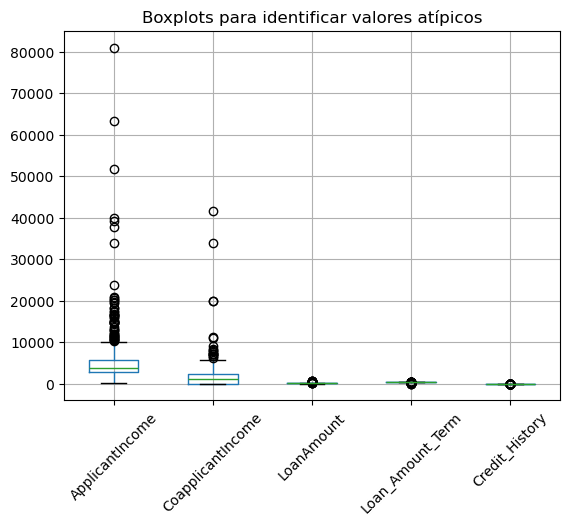

In [4]:
# Crea los boxplots para identifica valores atipicos
df.boxplot(rot=45)
plt.title("Boxplots para identificar valores atípicos")
plt.show()

# Parte 2: Análisis Exploratorio de Datos (EDA)
1. Análisis Estadístico Descriptivo:
Calcular estadísticas descriptivas básicas (media, mediana, desviación estándar, etc.).
Analizar la distribución de las variables categóricas.
2. Visualizaciones:
Crear histogramas y gráficos de barras para entender la distribución de las variables.
Crear un mapa de calor para visualizar las correlaciones entre las variables.
Utilizar gráficos de dispersión para identificar posibles relaciones entre las variables.
3. Valores Faltantes y Outliers:
Detectar y tratar valores faltantes.
Identificar y manejar outliers.

In [10]:
print(df.describe())

       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  614.000000             614.0   
mean       4617.111564        1419.702231  138.025354             360.0   
std        2479.851729        1624.605892   55.773951               0.0   
min         150.000000           0.000000    9.000000             360.0   
25%        2877.500000           0.000000  100.250000             360.0   
50%        3812.500000        1188.500000  129.000000             360.0   
75%        5795.000000        2297.250000  164.750000             360.0   
max       10171.250000        5743.125000  261.500000             360.0   

       Credit_History  
count           614.0  
mean              1.0  
std               0.0  
min               1.0  
25%               1.0  
50%               1.0  
75%               1.0  
max               1.0  


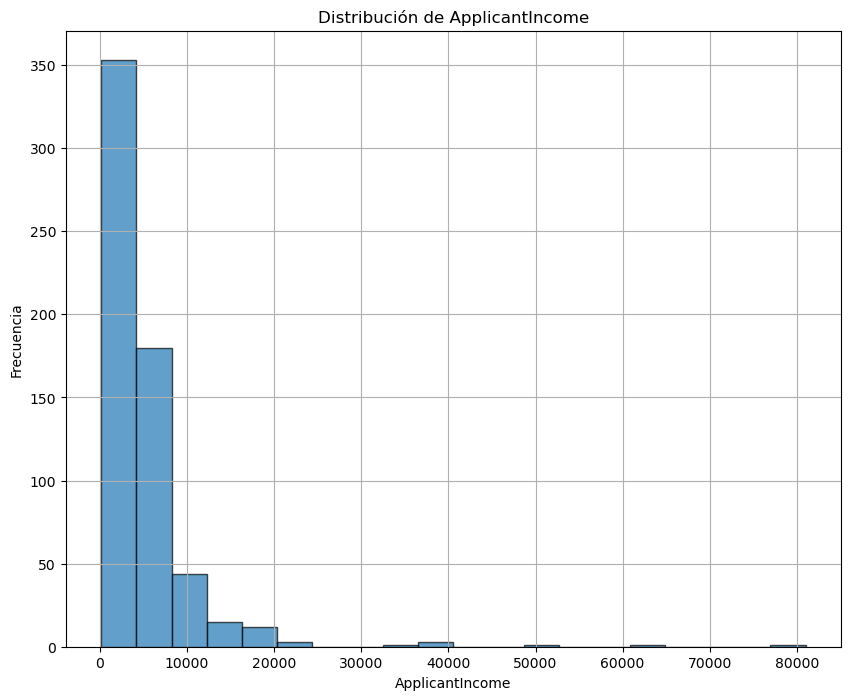

In [5]:
#Empezaré con algunos gráficos para entender mejor
plt.figure(figsize=(10, 8))
plt.hist(df['ApplicantIncome'], bins = 20, edgecolor = 'black', alpha = 0.7)
plt.title('Distribución de ApplicantIncome')
plt.xlabel('ApplicantIncome')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [6]:
#La mayor parte de los infresos están por debajo de 10.0000 
#Podría decir que las personas objetivo para los préstamos son persinas con ingresos medios o bajos
fig = px.histogram(df, x = 'LoanAmount', title='Distribución de LoanAmount')
fig.show()

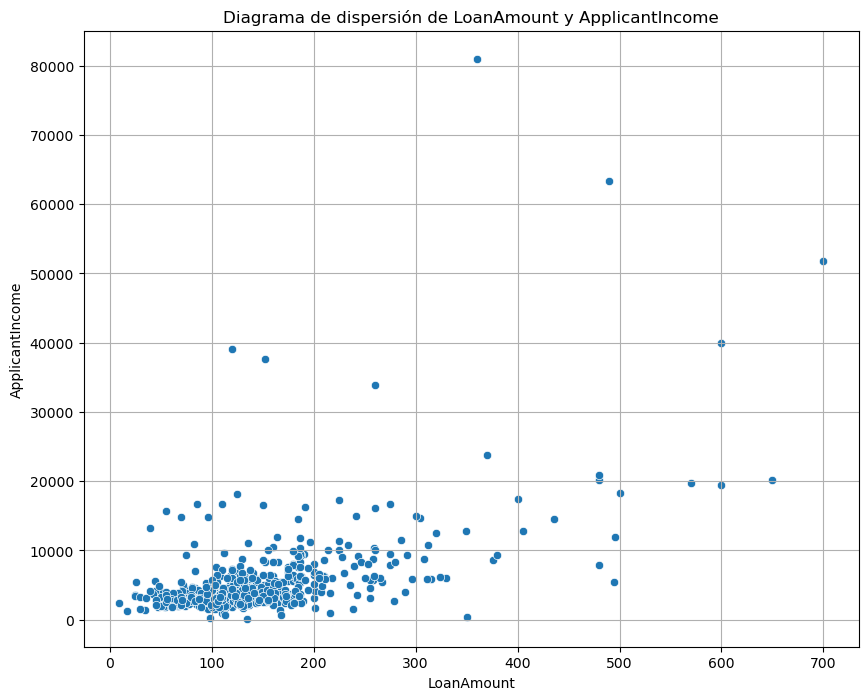

In [7]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x = 'LoanAmount', y = 'ApplicantIncome', data = df)
plt.title('Diagrama de dispersión de LoanAmount y ApplicantIncome')
plt.xlabel('LoanAmount')
plt.ylabel('ApplicantIncome')
plt.grid(True)
plt.show()

In [8]:
#Se elimina la columna que no sera necesaria 
df.drop(columns=['Loan_ID'],axis=1,inplace = True)

In [9]:
#Se maneja los valores faltantes de las columnas numericas con la media
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].mean())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mean())
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mean())

In [10]:
#Se maneja los valores faltantes de la categoria con la moda 
df.fillna({
    'Gender': df['Gender'].mode()[0],
    'Married': df['Married'].mode()[0],
    'Dependents': df['Dependents'].mode()[0],
    'Self_Employed': df['Self_Employed'].mode()[0]
}, inplace=True)

print("Valores nulos:\n", df.isnull().sum())

Valores nulos:
 Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


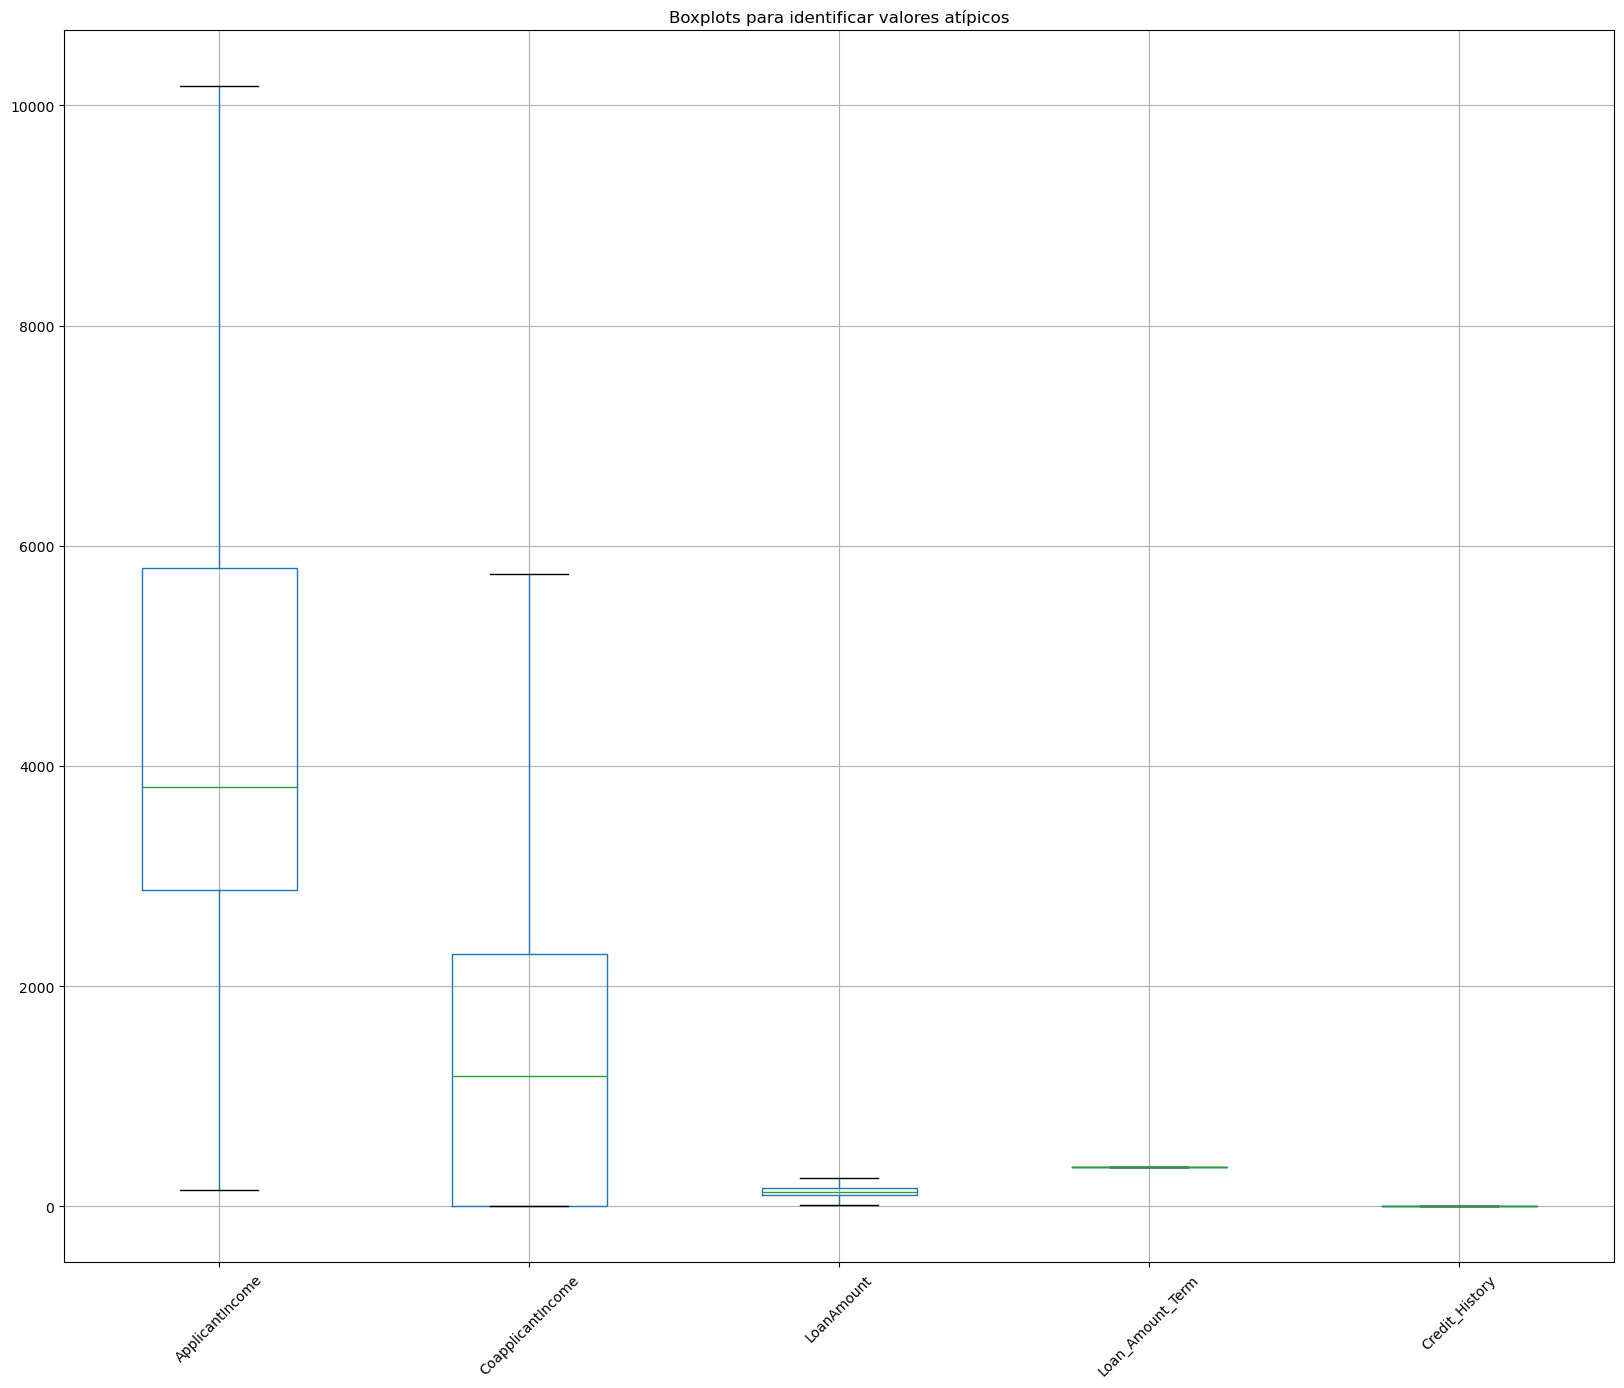

In [11]:
# Se encontraron valores atipicos considerables
# Manejo de valores atípicos usando el rango intercuartílico (IQR)
def eliminar_atipicos_iqr(data, column):
    # Calcular Q1, Q3 y el rango intercuartílico (IQR)
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    # Definir límites inferior y superior
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Reemplazar valores por los límites cuando estén fuera del rango
    data[column] = np.where(data[column] < lower_bound, lower_bound, data[column])
    data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])

# Aplicar la corrección para cada columna numérica
for col in df.select_dtypes(include=np.number).columns:
    eliminar_atipicos_iqr(df, col)

# Verificar los cambios con gráficos de caja (boxplots)
plt.figure(figsize=(20, 16))
# Crea los boxplots
df.boxplot(rot=45)
plt.title("Boxplots para identificar valores atípicos")
plt.show()

# Parte 3: Preprocesamiento de Datos
1. Transformación de Columnas:
Codificar variables categóricas utilizando One-Hot Encoding.
Escalar características numéricas utilizando StandardScaler.
2. División del Conjunto de Datos:
Dividir el dataset en conjuntos de entrenamiento y prueba.

In [12]:
df['Loan_Status'] = df['Loan_Status'].apply(lambda x:1 if x ==  'Y' else 0)

#Selecciono la variable objetivo y la separo
X = df.drop('Loan_Status', axis = 1) #Con esto selecciono todas las columnas, excepto Loan_Status
y = df['Loan_Status'] #Esta sería mi columna objetivo

#Ahora divido los conjuntos de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Ahora hago el pipeline.

num_columns = X.select_dtypes(include=['float64', 'int64']).columns
cat_columns = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore') )
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_columns),
        ('cat', categorical_transformer, cat_columns)
    ]
)

#Ahora hago el pipeline completo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Parte 4: Implementación de LightGBM (LGBM)
1. Entrenamiento del Modelo:
Entrenar un modelo de LGBM con hiperparámetros básicos.
Evaluar el modelo utilizando métricas de rendimiento como la exactitud, precisión, recall, F1-Score y ROC-AUC.
2. Optimización de Hiperparámetros:
Utilizar GridSearchCV para optimizar los hiperparámetros del modelo de LGBM.
3. Evaluación del Modelo Optimizado:
Evaluar el rendimiento del modelo optimizado y compararlo con el modelo inicial.

In [13]:
from lightgbm import LGBMClassifier
from sklearn.metrics import  classification_report

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42))
])

#Entreno el modelo
pipeline.fit(X_train, y_train)

#Hago las predicciones
y_pred = pipeline.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)

report_df = pd.DataFrame(report).T

print(f'Reporte de LightGBM: ')
print(report_df)


[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [14]:
#Utilizar GridSearch para tratar de mejorar
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    pipeline, param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Mejores Hiperparámetros: {grid_search.best_params_}")
print(f"Mejor Puntaje: {grid_search.best_score_:.4f}")

best_pipeline = grid_search.best_estimator_

y_pred = best_pipeline.predict(X_test)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 343
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Acer\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

